FastAi Beginner - Vision tutorial (https://docs.fast.ai/tutorial.vision.html)

In [1]:
from fastai2.vision.all import *

# Fastai Vision Tutorial - Classification

## Single-label Classification (Cat vs Dog)

In [2]:
# Get the data from Oxford-IIIT Pet Dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/)
path = untar_data(URLs.PETS)

In [3]:
path.ls()

(#3) [Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images'),Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/models')]

In [4]:
# get_image_files will grab all images in one folder recursively
files = get_image_files(path/'images')
print('Number of images:', len(files))

Number of images: 7390


In [5]:
# label 'cat' starts with a capital letter in front of the breed name and lowercase for 'dog'
files[0], files[5000]

(Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/pug_1.jpg'))

In [6]:
def get_label(f):
    return f[0].isupper()

In [7]:
# create a DataLoaders object before feeding the images into model
data_loaders = ImageDataLoaders.from_name_func(path, # our file directory 
                                               files, # images
                                               get_label, # labelling function
                                               item_tfms=Resize(224), # Transform (resize each image to 224x224)
                                               num_workers=0 # always set num_workers 0 in windows, sincce Pytorch multiprocessing does not work on Windows
                                              ) 

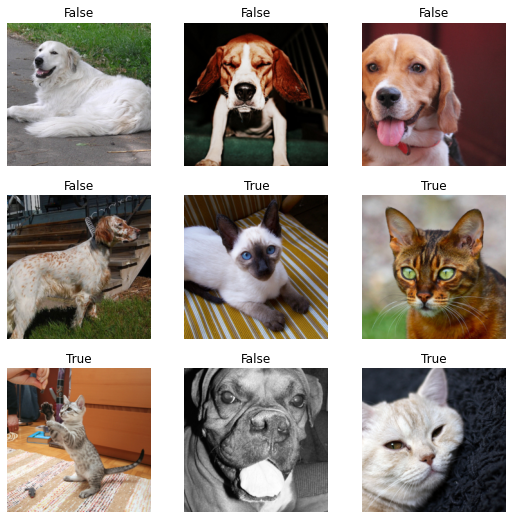

In [8]:
data_loaders.show_batch()

In [9]:
# creates a Learner object which combines data and model training and uses transfer learning to fine-tune a pre-trained model
learner = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learner.fine_tune(1)

In [10]:
learner.predict(files[0])

('True', tensor(1), tensor([0.0060, 0.9940]))

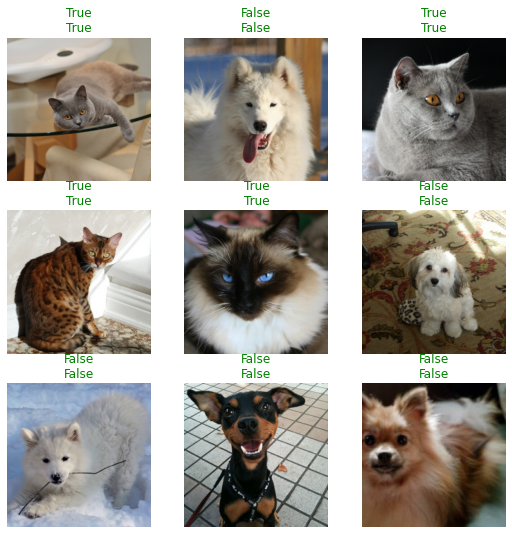

In [11]:
learner.show_results()

## Multi-label Classification (Breed Classification)

In [12]:
# every breed name ends with .jpg
files[0]

Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg')

In [13]:
breed = r'^(.*)_\d+.jpg'

In [14]:
data_loaders = ImageDataLoaders.from_name_re(path, files, breed, item_tfms=Resize(224), num_workers=0)

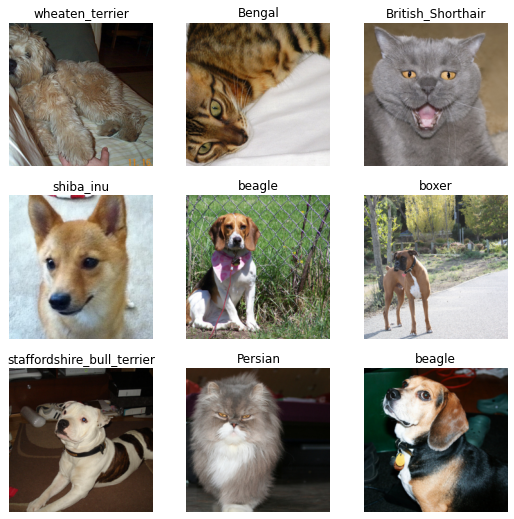

In [15]:
data_loaders.show_batch()

In [16]:
learner = cnn_learner(data_loaders, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.00363078061491251)

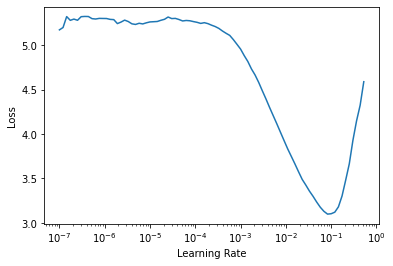

In [17]:
# find the best learning rate
learner.lr_find()

In [18]:
learner.fine_tune(2, 3e-3)

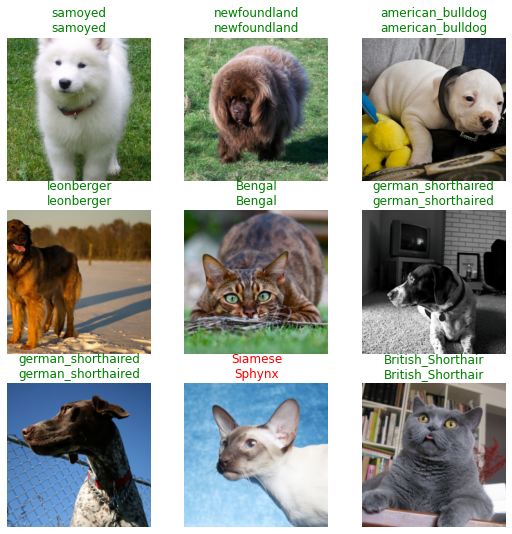

In [19]:
learner.show_results()

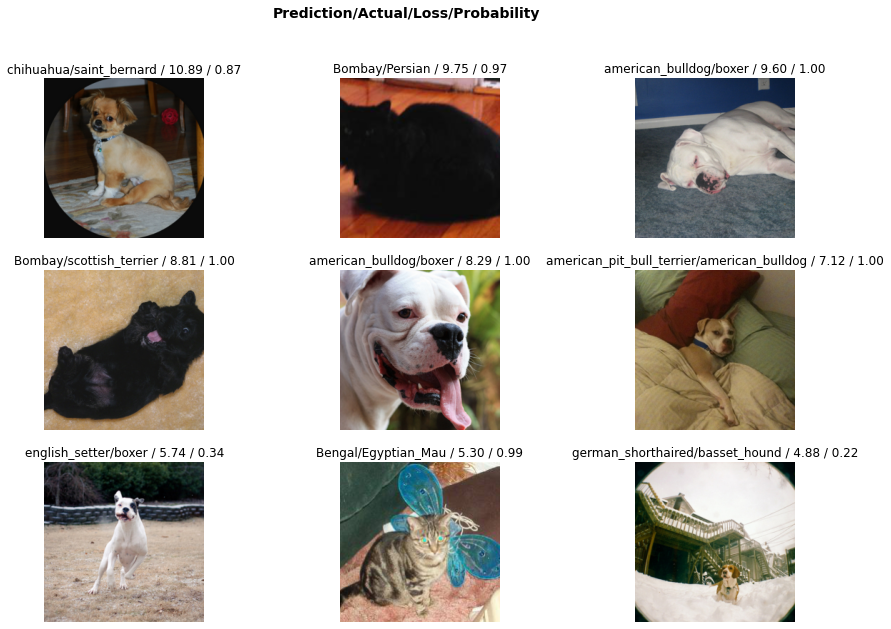

In [20]:
interpretation = Interpretation.from_learner(learner)
interpretation.plot_top_losses(9, figsize=(15,10))

## Single-label Classification - With the Data Block API

In [21]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(),
                get_y=using_attr(RegexLabeller(r'^(.*)_\d+.jpg'), 'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224))

In [22]:
data_loaders = pets.dataloaders(untar_data(URLs.PETS)/"images")

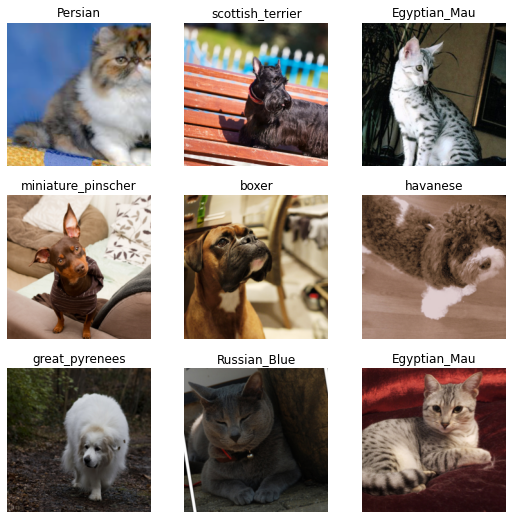

In [23]:
data_loaders.show_batch(max_n=9)

## Multi-label Classification - With High level API

In [2]:
# we will use the Pascal Dataset
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#9) [Path('C:/Users/Archel/.fastai/data/pascal_2007/models'),Path('C:/Users/Archel/.fastai/data/pascal_2007/segmentation'),Path('C:/Users/Archel/.fastai/data/pascal_2007/test'),Path('C:/Users/Archel/.fastai/data/pascal_2007/test.csv'),Path('C:/Users/Archel/.fastai/data/pascal_2007/test.json'),Path('C:/Users/Archel/.fastai/data/pascal_2007/train'),Path('C:/Users/Archel/.fastai/data/pascal_2007/train.csv'),Path('C:/Users/Archel/.fastai/data/pascal_2007/train.json'),Path('C:/Users/Archel/.fastai/data/pascal_2007/valid.json')]

In [3]:
path

Path('C:/Users/Archel/.fastai/data/pascal_2007')

In [4]:
# read in the csv file as usual with pandas
df = pd.read_csv('C:/Users/Archel/.fastai/data/pascal_2007/train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

In [5]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                              item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), num_workers=0)

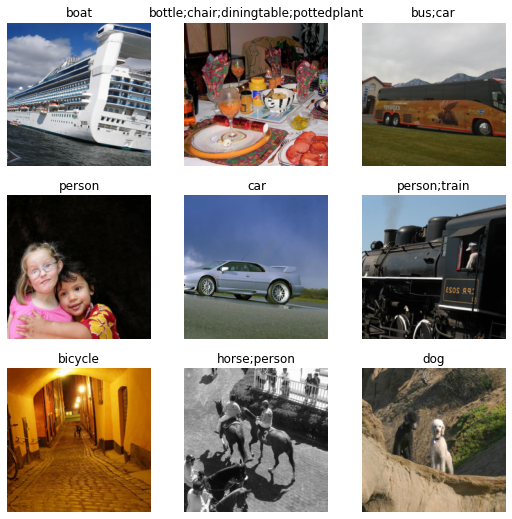

In [6]:
dls.show_batch()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.033113110810518265)

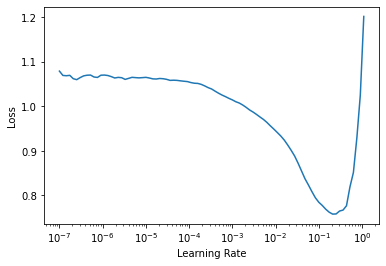

In [7]:
# we can use accuracy_thresh instead of error_rate for multiclass problem
learner = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=.5))
learner.lr_find()

In [8]:
learner.fine_tune(2, 3e-2)

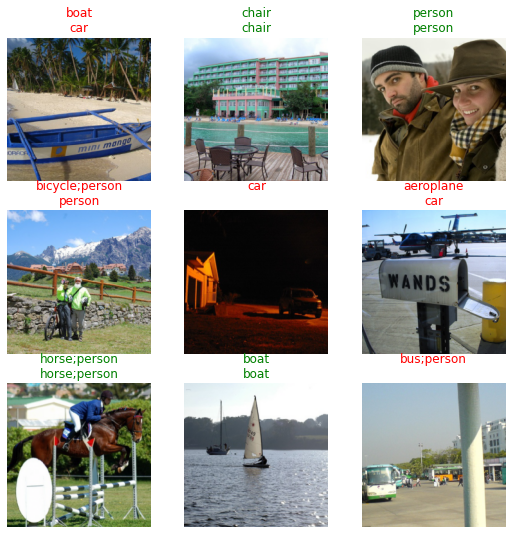

In [9]:
learner.show_results()

In [10]:
learner.predict('C:/Users/Archel/.fastai/data/pascal_2007/train/000005.jpg')

((#2) ['chair','diningtable'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
          True, False, False, False, False, False, False, False, False, False]),
 tensor([1.6363e-03, 4.3682e-03, 6.8426e-04, 2.6034e-04, 9.7357e-02, 2.3393e-03,
         2.0370e-03, 5.8037e-03, 9.2766e-01, 1.9562e-03, 6.3599e-01, 6.0270e-03,
         5.6451e-04, 1.7583e-04, 1.3951e-01, 3.8258e-01, 1.8280e-03, 1.5506e-01,
         7.8255e-03, 7.9823e-02]))

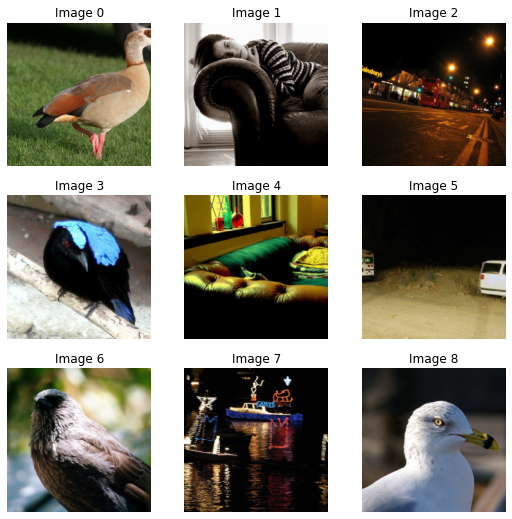

In [11]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9)

## Multi-label Classification - With the Data Block API

In [12]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), # we use ImageBlock and MultiCategoryBlock this time
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

In [13]:
dls = pascal.dataloaders(df)

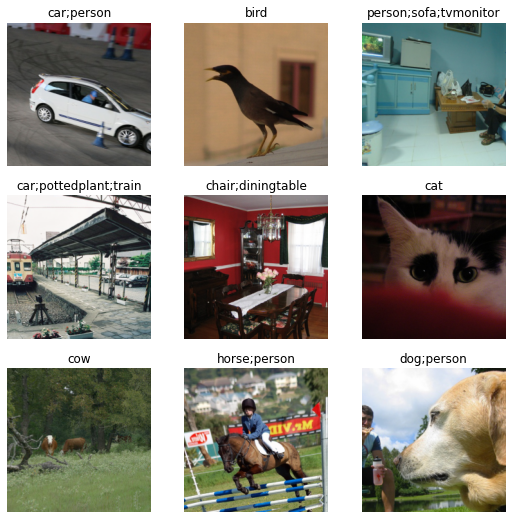

In [14]:
dls.show_batch()

# Fastai Vision Tutorial - Segmentation

In [3]:
# we will use CamVid dataset
path = untar_data(URLs.CAMVID_TINY)
path.ls()

[WindowsPath('C:/Users/Archel/.fastai/data/camvid_tiny/codes.txt'),
 WindowsPath('C:/Users/Archel/.fastai/data/camvid_tiny/images'),
 WindowsPath('C:/Users/Archel/.fastai/data/camvid_tiny/labels')]

The `images` folder contains the images, and the corresponding segmentation masks of labels are in the `labels` folder. The `codes` file contains the corresponding integer to class (the masks have an int value for each pixel).

In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Segmentation - With High-level API

In [5]:
fnames = get_image_files(path/"images")
fnames[0]

WindowsPath('C:/Users/Archel/.fastai/data/camvid_tiny/images/0001TP_006750.png')

In [6]:
# the label has an extra '_P'
(path/"labels").ls()[0]

WindowsPath('C:/Users/Archel/.fastai/data/camvid_tiny/labels/0001TP_006750_P.png')

In [7]:
# we can define a label function
def label_func(fn):
    return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [11]:
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes, bs=8, num_workers=0)

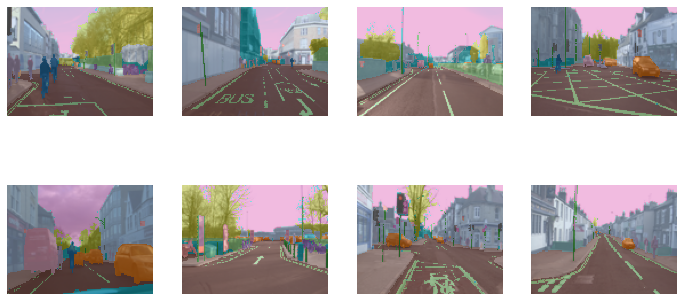

In [12]:
dls.show_batch()

In [13]:
# since convnet is not working on segmentation, we can use unet
learner = unet_learner(dls, resnet34)
learner.fine_tune(6)

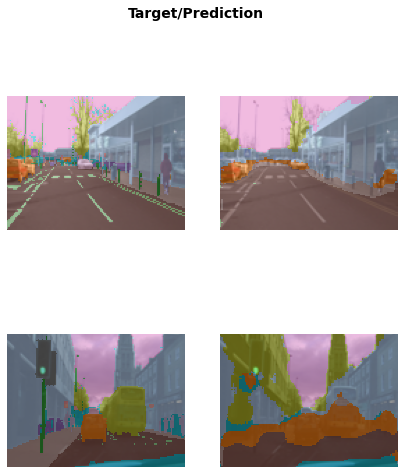

In [14]:
learner.show_results(max_n=6, figsize=(7,8))

In [16]:
# we can plot the model's error using SegmentationInterpretation class
interp = SegmentationInterpretation.from_learner(learner)
interp.plot_top_losses(k=3)

NameError: name 'SegmentationInterpretation' is not defined

## Segmentation - With DataBlock API

In [17]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)), # we pass codes to MaskBlock because there is no way to guess the labels from our data
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [18]:
dls = camvid.dataloaders(path/'images', path=path, bs=8)

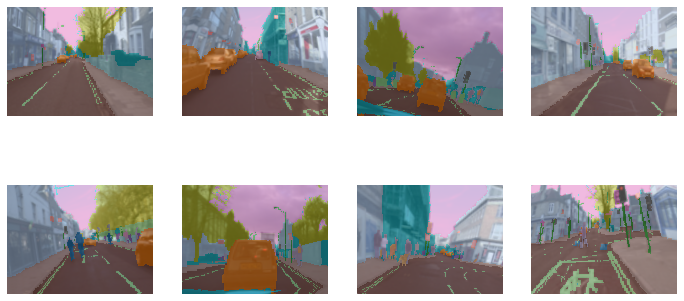

In [20]:
dls.show_batch()

# Fastai Vision Tutorial - Points

In [22]:
# for this tutorial we will use the Biwi Kinect Head Pose
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

In [23]:
(path/'01').ls()

(#1000) [Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/depth.cal'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [24]:
img_files = get_image_files(path)

In [29]:
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

In [30]:
img2pose(img_files[0])

Path('C:/Users/Archel/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [31]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

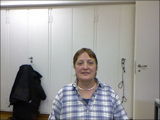

In [33]:
im.to_thumb(160)

In [34]:
# extract the head center point
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [35]:
# we can pass this to the DataBlock get_y parameter
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [42]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'), # don't use RandomSplitter, because we want to ensure that the model generalise to our dataset
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

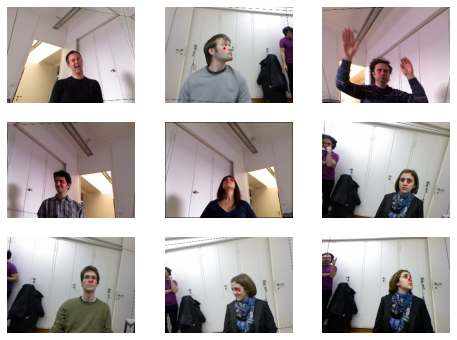

In [43]:
dls = biwi.dataloaders(path, num_workers=0)
dls.show_batch(max_n=9, figsize=(8,6))

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=7.585775847473997e-07)

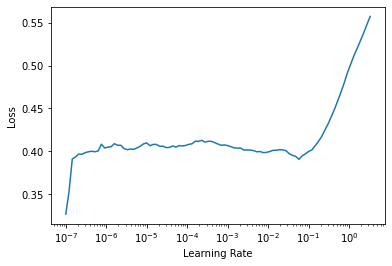

In [44]:
learner = cnn_learner(dls, resnet18, y_range=(-1,1))
learner.lr_find()

In [45]:
learner.fine_tune(1, 5e-3)

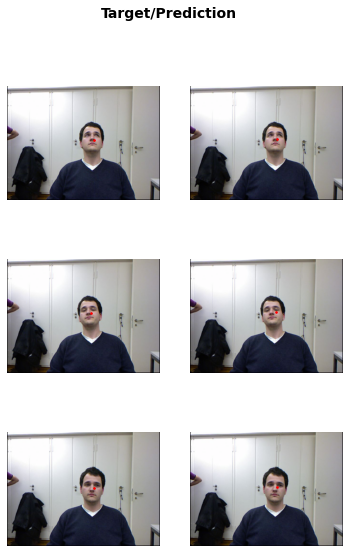

In [46]:
learner.show_results()